# チョコボールのエンゼルの出現確率を推定する

In [1]:
# ライブラリのインポート
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# プロットする図を綺麗にする
sns.set()

## データを確認する
エンゼルの有無は`angel`列に記録されており、数値との関係は以下の通り
- 0 : エンゼル無し
- 1 : 銀のエンゼル
- 2 : 金のエンゼル

`campaign`列に開催中のキャンペーンIDが記録されている。
キャンペーンID=1の商品は、金のエンゼルの出現確率は2倍だが、銀のエンゼルの出現確率は0%である。

In [20]:
# データの読み込み
data_raw = pd.read_csv('../data/chocoball_raw.csv')
tastes = pd.read_csv('../data/choco_tastes.csv')

print('data_raw.shape:', data_raw.shape)
print('tastes.shape:', tastes.shape)

data_raw.shape: (467, 9)
tastes.shape: (13, 4)


In [21]:
data_raw.head()

,No.,measure_date,best_before,weight,box_weight,ball_number,angel,campaign,taste
0,1,2017-11-19,NaN,34.002,4.756,16,0,1,0
1,2,2017-11-20,NaN,34.435,4.805,17,0,1,0
2,3,2017-11-21,2018-06-01,34.000,4.815,18,0,1,0
3,4,2017-11-22,2018-06-01,34.193,4.818,17,0,1,0
4,5,2017-11-23,2018-06-01,35.344,4.836,16,0,1,0


In [22]:
tastes

,id,name,name_en,spec
0,0,ピーナツ,peanut,28
1,1,いちご,strawberry,25
2,2,金のきなこもち,kinako,29
3,3,レモングミ,lemon,29
4,4,甘酒,amazake,22
5,5,キャラメル,caramel,28
6,6,カスタード,custard,22
7,7,パチパチ,pachipachi,26
8,8,ラムネ,ramune,23
9,9,パンプキン,pumpkin,22


エンゼルの出現数を確認する

In [6]:
data_raw.groupby(['campaign', 'angel']).count()[['taste']]

taste
campaign angel       
0        0        217
         1         12
1        0        113
         2          1
2        0          8
3        0        111
         1          5

銀のエンゼルの出現確率を予測する際に、`campaign=1`のデータを使わないようにする。

In [7]:
df_data = data_raw[data_raw['campaign']!=1]
print('df_data.shape:', df_data.shape)
df_data.groupby(['campaign', 'angel']).count()[['taste']]

df_data.shape: (353, 9)


taste
campaign angel       
0        0        217
         1         12
2        0          8
3        0        111
         1          5

In [23]:
df_data.groupby(['angel']).count()[['taste']]

,taste
angel,
0,336
1,17


## 仮定
- エンゼルはランダムに入っている
- 時期やフレーバーに依って確率は変化しない


## 最尤推定でパラメータを推定する

### モデル設定
- (スライド参照)
- エンゼルの出現を二項分布でモデル化する
  - エンゼルの出現確率を$\theta$とする
  - チョコボールの購入数（試行数）を$n$とする
$$
f(k|\theta) = \binom{n}{k}\theta^{k}(1-\theta)^{n-k}
$$

### 最尤推定量の計算
- (スライド参照)
- 求めたいパラメータはエンゼルの出現確率である$\theta$
- 最尤推定では、対数尤度$\log{L(\theta|X)}$をパラメータ$\theta$で微分して0となる値を推定値とする

$$
L(\theta|X)=\prod^{N}_{i=1}{f(k|\theta)} = \binom{n}{k}\theta^{k}(1-\theta)^{n-k} \\
\log{L(\theta|X)} = \log{\binom{n}{k}\theta^{k}(1-\theta)^{n-k}} \\
\qquad\qquad\qquad\qquad\qquad = \log{\binom{n}{k}} + \theta\log{{k}} + (1-\theta)\log{{n-k}} \\
$$

微分して0となるパラメータ

$$
\frac{d\log{L(\theta|X)}}{d\theta} = 0 \\
\hat{\theta} = \frac{k}{n}
$$

ということで、長々と数式を展開してきたが、結局は標本平均となる。

In [8]:
theta_l = np.sum(df_data['angel']) / np.size(df_data['angel'].values)
print('estimated value(MLP):', theta_l)

estimated value(MLP): 0.04815864022662889


### 推定値の活用
統計モデリングができたら、その結果を活用して様々なことができる。

#### 推定値をパラメータとした二項分布を確認
二項分布は試行数nを所与として、何回あたりを引くかの分布。

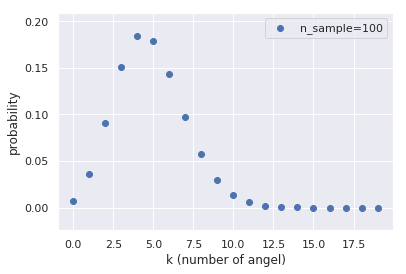

In [26]:
ks = np.arange(0, 20, 1)
n = 100

# 確率質量関数を計算
pmf = stats.binom.pmf(ks, n, p=theta_l)

# Plot
plt.scatter(ks, pmf, label='n_sample={}'.format(n))
plt.legend()
plt.xlabel('k (number of angel)')
plt.ylabel('probability')
plt.savefig('binom_mle.png')

#### 何個買えばエンゼルが5個当たるのか？を予測
- 二項分布のパラメータのうち、あたりの数を所与として試行回数を変えて見た場合の分布
  - 二項分布の定義式（下記）より、試行回数についての分布ではないので、以下の図は確率分布ではないことに注意
$$
f(k|\theta) = \binom{n}{k}\theta^{k}(1-\theta)^{n-k}
$$

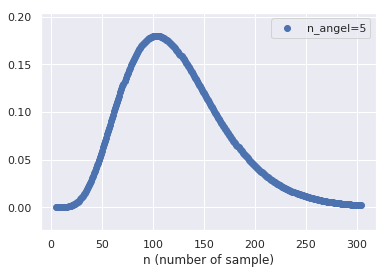

In [10]:
k = 5
ns = np.arange(k+0, k+300, 1)
pmf = list()
for n in ns:
    pmf.append(stats.binom.pmf(k, n, p=theta_l))
plt.scatter(ns, pmf, label='n_angel={}'.format(k))
plt.xlabel('n (number of sample)')
plt.legend()
plt.savefig('binom_mle_change_n.png')

#### 何個買えばエンゼルが5個当たるのか？の確率分布
- 上記の推定を確率分布で考える場合、負の二項分布を利用する
  - $k$ : 成功数（エンゼルの出現数）
  - $x$ : k回成功するまでの失敗回数
  - $\theta$ : 1回の成功確率（エンゼルの出現確率）
$$
f(x|\theta) = \binom{k+x-1}{x}\theta^{k}(1-\theta)^{x}
$$

50% Over point:92, (87+5)


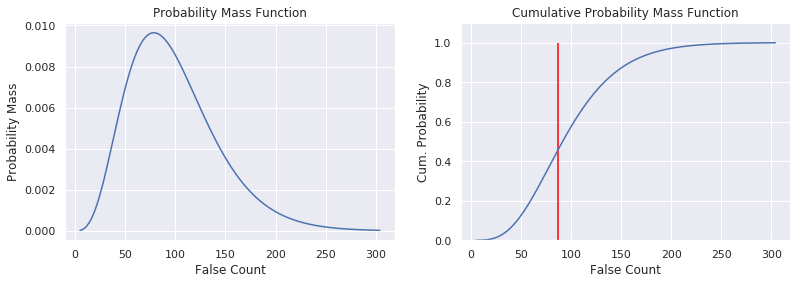

In [11]:
k = 5
xs = np.arange(k+0, k+300, 1)
pmf_nb = stats.nbinom.pmf(xs, k, theta_l)
cdf_nb = pmf_nb.cumsum()

first_over_50 = list(cdf_nb).index(cdf_nb[cdf_nb>0.5].min())

fig = plt.figure(figsize=(13, 4))
ax = fig.subplots(1, 2)

ax[0].plot(xs, pmf_nb)
ax[0].set_title('Probability Mass Function')
ax[0].set_xlabel('False Count')
ax[0].set_ylabel('Probability Mass')
ax[1].plot(xs, cdf_nb)
ax[1].set_title('Cumulative Probability Mass Function')
ax[1].set_xlabel('False Count')
ax[1].set_ylabel('Cum. Probability')
ax[1].set_ylim([0.0, 1.1])
ax[1].vlines(x=first_over_50, ymin=0, ymax=1.0, color="red", label="50% Over")
print('50% Over point:{}, ({}+{})'.format(first_over_50 + k, first_over_50, k))
plt.savefig('purchase_number_mle.png')

#### エンゼルの出現をシミュレーション

Sequential sampling (1 chains in 1 job)
Metropolis: [x]
100%|██████████| 1500/1500 [00:00<00:00, 2159.61it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


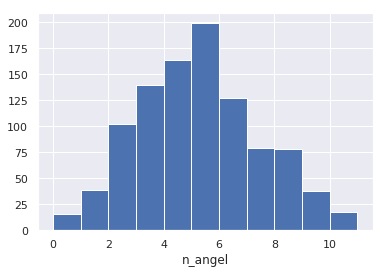

In [12]:
with pm.Model() as model_angel:
    x = pm.Binomial('x', n=100, p=theta_l)
    trace = pm.sample(1000, chains=1)
    
b = np.arange(0, max(trace['x'])+1, 1)
plt.hist(trace['x'], bins=b)
plt.xlabel('n_angel')
plt.savefig('simulation_mle.png')

## ベイズ推定でパラメータを推定する

### モデル設定
- (スライド資料参照)
- ベイズの式を思い出す
    - $p(\theta | x) \propto p(x | \theta)p(\theta)$
    - x : n個のチョコボールを開封して出たエンゼルの数
    - $\theta$ : 確率分布のパラメータ（エンゼルの含有率）
    - 尤度$p(x | \theta)$と事前分布$p(\theta)$を設定する必要がある
- 尤度関数
    - 最尤推定と同様に、二項分布を利用
    - $p(x | \theta) = \binom{n}{x}\theta^x(1-\theta)^{N-x}$
- 事前分布
    - ベータ分布
    - $p(\theta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}$


#### ベータ分布の形状を見てみる

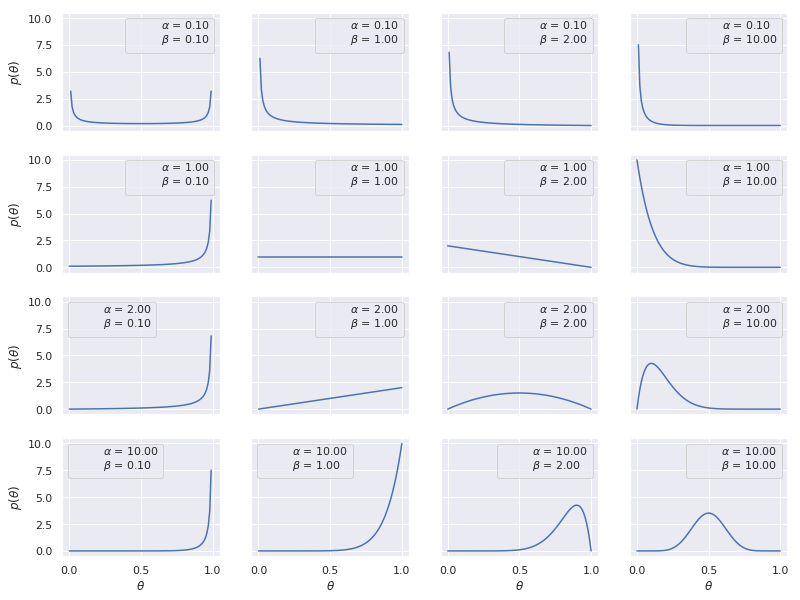

In [13]:
params = [0.1, 1, 2, 10] # alpha, betaの例

x = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(13, 10))
ax = fig.subplots(len(params), len(params), sharex=True, sharey=True)
cnt=0
for i in range(len(params)):
    for j in range(len(params)):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i, j].plot(x, y)
        ax[i, j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(a, b), alpha=0)
        ax[i, j].legend()
        if i == (len(params)-1):
            ax[i,j].set_xlabel('$\\theta$')
        if j == 0:
            ax[i,j].set_ylabel('$p(\\theta)$')
plt.savefig('beta_dist_var.png')

### 解析的な計算方法(共役事前分布)

ベイズの定理を再度思い出す。
事後分布は尤度関数と事前分布の積に比例するという式である。
$$
p(\theta | y) \propto p(y | \theta)p(\theta)
$$
尤度関数には、二項分布で事前分布はベータ分布と定義したので、
ベイズの定理は以下のような式になる。
$$
p(\theta | y) \propto \frac{N!}{y!(N-y)!}\theta^y(1-\theta)^{N-y}\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}
$$

$\theta$に関係しない部分は比例定数として押し込めてしまうことで、
以下の式が得られる。

$$
p(\theta | y)　\propto \theta^{\alpha-1+y}(1-\theta)^{\beta-1+N-y}
$$

この式はベータ分布に一致する。
$$
p(\theta | y)　= Beta(\alpha_{prior}+y, \beta_{prior}+N-y)
$$

つまり、今回のモデル定義においては、解析的に事後分布を導くことができた。  
このように尤度関数との積が同じ関数になる事前分布を「共役事前分布」と呼ぶ。
共役事前分布をモデルに利用すれば解析的に解を求めることができるが、
もっと複雑なモデルを使う場合には、一般的に解析解が得られない。

### 数値的な計算方法(MCMC)

#### 計算の実行
複雑なモデルや共役でない事前分布を使う場合、計算が困難か解析的には計算が不可能な場合がある。  
このような場合にも事後分布を計算するアルゴリズムとして、
マルコフチェーンモンテカルロ（MCMC）と呼ばれるアルゴリズムがある。  
詳細は省略するが、ざっくりとしたイメージでは、形状がわからない確率分布（事後分布）の大きさに比例してデータをサンプルするアルゴリズムである。

In [14]:
d_angel = df_data['angel'].values
n_sample = 10000

with pm.Model() as model_angel:
    # 事前分布の設定
    #theta = pm.Uniform('theta', lower=0, upper=1) # 一様分布
    theta = pm.Beta('theta', alpha=1.0, beta=1.0) # 一様分布
    #theta = pm.Beta('theta', alpha=1, beta=2) # 上記ベータ分布の例参照
    
    # 尤度関数の設定
    obs = pm.Binomial('obs', n=len(d_angel), p=theta, observed=sum(d_angel))
    #obs = pm.Bernoulli('obs', p=theta, observed=d_angel) # ベルヌーイ分布
    
    # MCMCサンプルを得る
    trace = pm.sample(n_sample, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 2252.08draws/s]
The acceptance probability does not match the target. It is 0.8930255659337233, but should be close to 0.8. Try to increase the number of tuning steps.


#### 結果の解釈

推定対象である、二項分布のパラメータ$\theta$(エンゼルの含有率)の事後分布を確認する。
なお、以下の図はchain数（MCMCサンプル系列の数）分の結果が同時に表示されている。
- 左図:$\theta$の事後分布
- 右図:$\theta$のサンプル系列。ランダムにサンプルされていることが望ましい。

/Users/tok41/workspace/seminar_choco/env_sc/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


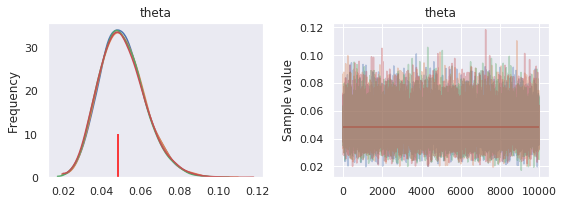

In [15]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,2)
ax = ax[np.newaxis, :]

pm.traceplot(trace, ax=ax)
ax[0,0].vlines(x=theta_l, ymin=0, ymax=10, color="red", label="MLE")
ax[0,1].hlines(y=theta_l, xmin=0, xmax=n_sample, color="red", label="MLE")

plt.savefig('trace_plot_angel_rate.png')

次に、統計量を確認する。

In [16]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.050523,0.011604,0.000098,0.029192,0.073974,15652.341605,1.000065


- mean:事後分布の期待値
- sd:サンプルの標本標準偏差
- mc_error:サンプリングに起因する誤差の推定値
- hpd_2.5:95%信用区間の下限
- hpd_97.5:95%信用区間の上限
- n_eff:サンプルサイズの効果量
- Rhat:chain間の分散とchain内の分散の比のようなもの。1に近いほど良い。大きい場合は、収束していないchainがある。

chainを全て統合して、事後分布を推定。
- 信用区間(HPD)をalpha_levelで指定

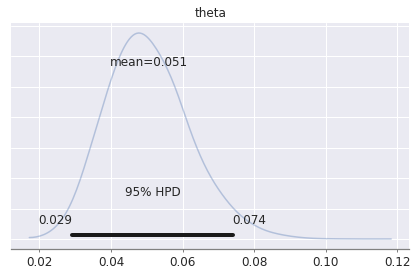

In [17]:
pm.plot_posterior(trace, kde_plot=True, alpha_level=0.05)
plt.savefig('posterior_angel_rate.png')

#### 何個買えばエンゼルが5個当たるのか？
- 最尤推定の場合と同様に負の二項分布を利用して推定する

50.0% Over point:56 ~ 83 ~ 131 (alpha_level=0.1)


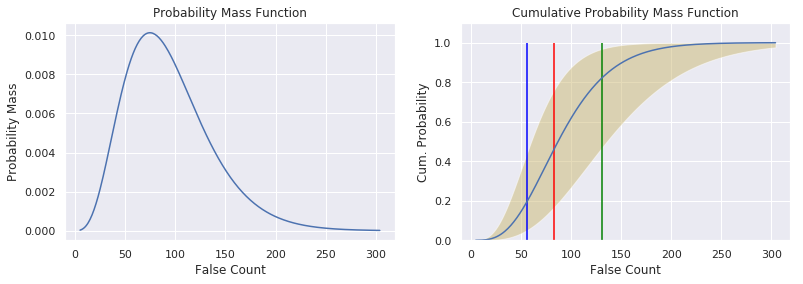

In [18]:
theta_tr = trace['theta']
alpha_level = 0.1
k = 5
xs = np.arange(k+0, k+300, 1)
pmf_nb_ex = stats.nbinom.pmf(xs, k, theta_tr.mean())
pmf_nb_lb = stats.nbinom.pmf(xs, k, np.percentile(theta_tr, (alpha_level*50.0)))
pmf_nb_ub = stats.nbinom.pmf(xs, k, np.percentile(theta_tr, (100.0-alpha_level*50.0)))
cdf_nb_ex = pmf_nb_ex.cumsum()
cdf_nb_lb = pmf_nb_lb.cumsum()
cdf_nb_ub = pmf_nb_ub.cumsum()

ex_p = 0.5
first_over_ex = list(cdf_nb_ex).index(cdf_nb_ex[cdf_nb_ex>ex_p].min())
first_over_lb = list(cdf_nb_lb).index(cdf_nb_lb[cdf_nb_lb>ex_p].min())
first_over_ub = list(cdf_nb_ub).index(cdf_nb_ub[cdf_nb_ub>ex_p].min())

fig = plt.figure(figsize=(13, 4))
ax = fig.subplots(1, 2)

ax[0].plot(xs, pmf_nb_ex)
ax[0].set_title('Probability Mass Function')
ax[0].set_xlabel('False Count')
ax[0].set_ylabel('Probability Mass')
ax[1].plot(xs, cdf_nb_ex)
ax[1].fill_between(xs, cdf_nb_lb, cdf_nb_ub, facecolor='y',alpha=0.5)
ax[1].set_title('Cumulative Probability Mass Function')
ax[1].set_xlabel('False Count')
ax[1].set_ylabel('Cum. Probability')
ax[1].set_ylim([0.0, 1.1])
ax[1].vlines(x=first_over_ex, ymin=0, ymax=1.0, color="red", label="{}% Over (ex)".format(ex_p))
ax[1].vlines(x=first_over_lb, ymin=0, ymax=1.0, color="green", label="{}% Over (lb)".format(ex_p))
ax[1].vlines(x=first_over_ub, ymin=0, ymax=1.0, color="blue", label="{}% Over (ub)".format(ex_p))
print('{}% Over point:{} ~ {} ~ {} (alpha_level={})'.format(ex_p*100, first_over_ub, first_over_ex, first_over_lb, alpha_level))
plt.savefig('purchase_number_bayes.png')